# SHRED Implementation

This notebook walks the user through a standard SHRED implementation. After reading this notebook, you should be able to understand how to implement a SHRED model for you dataset.

The first step is to load your data. In this notebook, we will be using Sea-Surface Temperature data from [NOAA](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html). You can download the data from [here](https://drive.google.com/drive/folders/10XM9BTDDeaeBwoDK4alWFsnnG42km3FR?usp=sharing). Place the `SST_data.mat` file in the top-level `data/sst/` directory.

## Imports and Parameters

In [17]:
%load_ext autoreload
%autoreload 2

import pprint as pp
from typing import cast

import einops
import torch

import shredx

input_length = 10
n_epochs = 50
lr = 1e-4
forecast_length = 1
n_sensors = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Data

The SST dataset can be loaded using our `datasets` module. The dataloader is a `TimeSeriesDataset`. This dataset allows for flexible input and output tensor configuration. It returns a tuple of two windows with `input_length + forecast_length` timesteps. You can have the input and output tensors be different, as long as they have the same number of timesteps. This allows you to train from sparse sensor measurements of a dense field and then output to POD modes (as in [SHRED-ROM](https://www.nature.com/articles/s41467-025-65126-y.pdf)) or to the full state field (as in base [SHRED](https://royalsocietypublishing.org/rspa/article/480/2298/20240054/66770)).

Here, we load the SST data so that the input and output tensors are the same.

In [2]:
# Load dataset
train_ds, valid_ds, test_ds, metadata = shredx.datasets.datasets.load_sst_data(
    input_length=input_length, forecast_length=forecast_length
)

# Show values
sample = train_ds[0]
print("Input sample shape:", sample[0].shape)
print("Output sample shape:", sample[0].shape)  # Can output to POD modes instead if we want

n_timesteps = sample[0].shape[0]
n_rows = sample[0].shape[1]
n_cols = sample[0].shape[2]
n_channels = sample[0].shape[3]

Input sample shape: torch.Size([11, 180, 360, 1])
Output sample shape: torch.Size([11, 180, 360, 1])


## Data Visualization

To visualize our data, we will be using the `plots` module. This allows us to plot our dense SST time series data.

We also use the `sst_zeros` metadata to show where dynamics occur for this dataset.

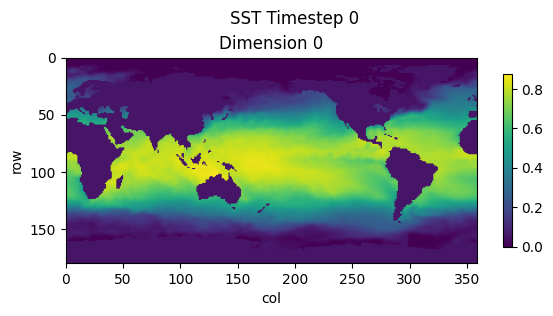

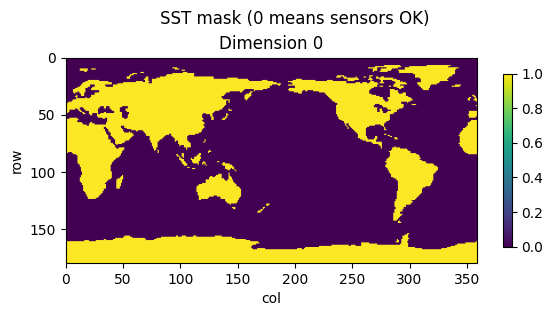

In [3]:
shredx.utils.plots.plot_timestep(sample[0][0], title="SST Timestep 0", save=False)

shredx.utils.plots.plot_timestep(metadata["sst_zeros"], title="SST mask (0 means sensors OK)", save=False)

## Sensor Extraction

To extract sensors from our input sample, we use the `sensors` module and once again plot using the `plots` module.


Sensor locations:
[{'x': 81, 'y': 272},
 {'x': 144, 'y': 31},
 {'x': 36, 'y': 191},
 {'x': 160, 'y': 291},
 {'x': 141, 'y': 129}]

Sensor values shape: torch.Size([11, 5, 1])



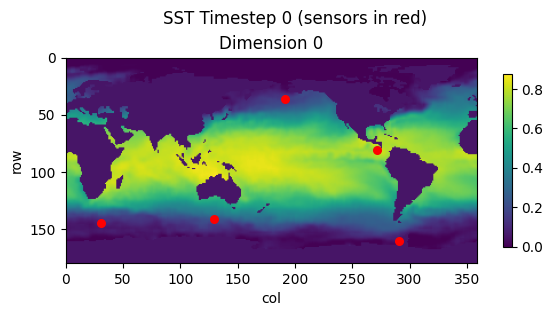

In [ ]:
mask = metadata["sst_zeros"]
sensor_locations = shredx.utils.sensors.generate_static_sensors_from_mask(n_sensors, mask, dim_agnostic=True)
sensor_locations = cast(list[tuple[int, int]], sensor_locations)

print("Sensor locations:")
pp.pprint([{"x": x, "y": y} for x, y in sensor_locations])
print()

sensor_values = shredx.utils.sensors.extract_static_sensors(sample[0], sensor_locations)
print("Sensor values shape:", sensor_values.shape)
print()

shredx.utils.plots.plot_timestep(
    sample[0][0], title="SST Timestep 0 (sensors in red)", save=False, sensors=sensor_locations
)

## Defining SHRED

We will use the `MixedModel` class to define our SHRED model. We will use an LSTM as the encoder and an MLP as a decoder implemented in the `LSTMEncoder` and `MLPDecoder` classes. Here, we pass the sensor values into a newly initiated SHRED model. Note that the output to SHRED models are formatted as `[batch, time, sequence_length, rows, columns, dimension]`. In this case, `time`, `sequence_length`, and `dimension` are 1 and we reshape the output to `[1, rows, columns]`.

In [ ]:
lstm_encoder = shredx.modules.rnn.LSTMEncoder(
    input_size=n_sensors * n_channels, hidden_size=n_sensors, num_layers=3, dropout=0.0, device=device
)
mlp_decoder = shredx.modules.mlp.MLPDecoder(
    in_dim=n_sensors, out_dim=n_rows * n_cols * n_channels, n_layers=2, dropout=0.0, device=device
)
shred = shredx.models.mixed_model.MixedModel(lstm_encoder, mlp_decoder)

# Squish sensor_values dimension and n_sensors to one dimension
sensor_values_batch = einops.rearrange(sensor_values, "t s 1 -> 1 t (s 1)")
if sensor_values_batch is None:
    raise ValueError("sensor_values_batch is None")
sensor_values_batch = sensor_values_batch.to(device)

# Verify we can pass data into SHRED
with torch.no_grad():
    output, _ = shred(sensor_values_batch)
    print("SHRED Output shape:", output.shape)
    output = einops.rearrange(output, "1 t s (r c) -> (1 t s) r c 1", r=n_rows, c=n_cols)
    print("SHRED Output reshaped:", output.shape)
None

SHRED Output shape: torch.Size([1, 1, 1, 64800])
SHRED Output reshaped: torch.Size([1, 180, 360, 1])


## Training Loop

We train SHRED to reconstruct the next timestep from the sparse sensor measurements.

In [ ]:
optimizer = torch.optim.Adam(shred.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
losses = []

for i in range(n_epochs):
    for batch in train_ds:
        # Load data
        input_window, output_window = batch

        # Prepare inputs and outputs
        input_window = input_window[:input_length]
        output_window = output_window[input_length : input_length + forecast_length]
        input_window = input_window.to(device)
        output_window = output_window.to(device)

        # Prepare input sensors
        input_sensors = shredx.utils.sensors.extract_static_sensors(input_window, sensor_locations)
        input_sensors = einops.rearrange(input_sensors, "t s 1 -> 1 t (s 1)")
        input_sensors = input_sensors.to(device)

        # Pass into model
        optimizer.zero_grad()
        output, _ = shred(input_sensors)

        # Compute loss
        output = einops.rearrange(output, "1 t s (r c) -> (1 t s) r c 1", r=n_rows, c=n_cols)
        loss = loss_fn(output, output_window)
        loss.backward()
        optimizer.step()

        # Log loss
        losses.append(loss.item())

    # Print progress
    if i % 10 == 0 or i == n_epochs - 1:
        print(f"Epoch {i}, Loss: {loss.item()}")

Epoch 0, Loss: 0.001979271648451686
Epoch 10, Loss: 0.002163368510082364
Epoch 20, Loss: 0.0018407716415822506
Epoch 30, Loss: 0.0004043968510814011
Epoch 40, Loss: 0.00025865263887681067
Epoch 49, Loss: 0.0003812533395830542


## Visualizing Outputs

Once SHRED is trained, we can pass in a set of test sensors and visualize the output. We use the metadata `scalers` to do the inverse min-max normalization of the output data.

SHRED Output shape: torch.Size([1, 1, 1, 64800])
SHRED Output reshaped: torch.Size([1, 180, 360, 1])


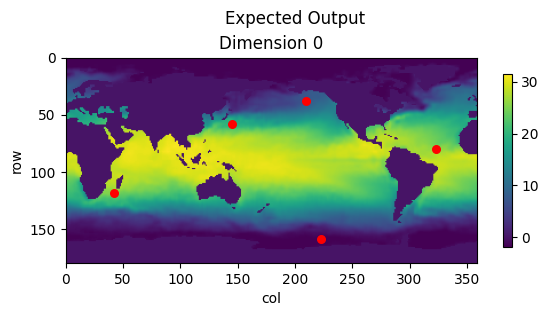

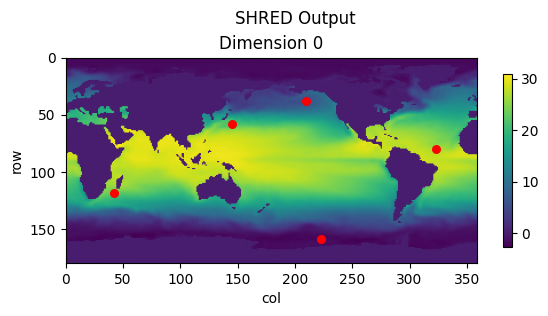

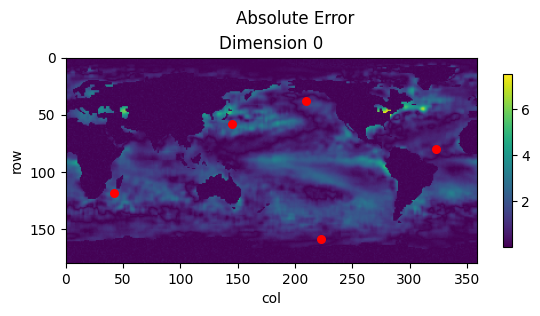

In [16]:
# Extract test sensors
sensor_values = shredx.utils.sensors.extract_static_sensors(test_ds[0][0], sensor_locations)
sensor_values_batch = einops.rearrange(sensor_values, "t s 1 -> 1 t (s 1)")
sensor_values_batch = sensor_values_batch.to(device)

# Verify we can pass data into SHRED
with torch.no_grad():
    output, _ = shred(sensor_values_batch)
    print("SHRED Output shape:", output.shape)
    output = einops.rearrange(output, "1 t s (r c) -> (1 t s) r c 1", r=n_rows, c=n_cols)
    print("SHRED Output reshaped:", output.shape)
    output = output[0].detach().cpu()

    # Inverse min-max scaling
    scaler = metadata["scalers"][0]
    output = shredx.utils.scaling.inverse_min_max_scale(output, original_min_max=scaler)
    expected = shredx.utils.scaling.inverse_min_max_scale(
        test_ds[0][1][input_length + forecast_length - 1], original_min_max=scaler
    )

    # Plot
    shredx.utils.plots.plot_timestep(expected, title="Expected Output", save=False, sensors=sensor_locations)
    shredx.utils.plots.plot_timestep(output, title="SHRED Output", save=False, sensors=sensor_locations)
    shredx.utils.plots.plot_timestep(
        torch.abs(output - expected), title="Absolute Error", save=False, sensors=sensor_locations
    )